In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV, RandomizedSearchCV, train_test_split, learning_curve, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
import graphviz

In [2]:
import seaborn as sns

In [3]:
full_data = pd.read_csv('faults.csv')

In [4]:
print(full_data.shape)
print("Number of rows: "+str(full_data.shape[0]))
print("Number of columns: "+str(full_data.shape[1]))

(1941, 28)
Number of rows: 1941
Number of columns: 28


In [5]:
full_data.columns

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'target'],
      dtype='object')

In [ ]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x='target', data=full_data, ax=ax[0])
_ = full_data['target'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])

In [ ]:
full_data.plot(kind="density", layout=(6,5), 
             subplots=True,sharex=False, sharey=False, figsize=(15,15))
plt.show()

In [6]:
full_data['target'].unique()

array(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps',
       'Other_Faults'], dtype=object)

In [7]:
full_data['target'] = pd.Categorical(full_data['target']).codes

In [8]:
full_data.isnull().values.any()
full_data2=full_data.dropna(axis=0)

In [9]:
full_data2.isnull().values.any()

False

In [10]:
X = full_data2.iloc[:, 0:27]
Y = full_data2.iloc[:, -1]

In [11]:
X_scaled = scale(X)
#Y = y.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y,train_size=0.75, test_size=0.25, random_state=666)

## Define the function for learning curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

## DT

In [12]:
DT = DecisionTreeClassifier(random_state=6666)
DT = DT.fit(X_train,y_train)
cv_score= cross_val_score(DT,X_train,y_train,cv=5).mean()
test_score = DT.score(X_test,y_test)
print(cv_score, test_score)

0.7180579562785968 0.7414529914529915


In [13]:
# random search 
param_dist = {"max_depth":[*range(1,15)],
        "splitter":("best","random"),
        "criterion":("gini","entropy"),
        "min_samples_leaf":[*range(1,15)],
        "min_samples_split":[*range(2,15)]
       }
n_iter_search = 300
cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=6666)
random_search = RandomizedSearchCV(DT, param_distributions=param_dist, cv=cv,n_iter=n_iter_search, random_state=666)
from time import time
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
best_estimator_DT = random_search.best_estimator_
print(best_estimator_DT)
print(random_search.best_score_)

RandomizedSearchCV took 14.10 seconds for 300 candidates parameter settings.
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=5,
                       min_samples_split=10, random_state=6666)
0.7459074733096085


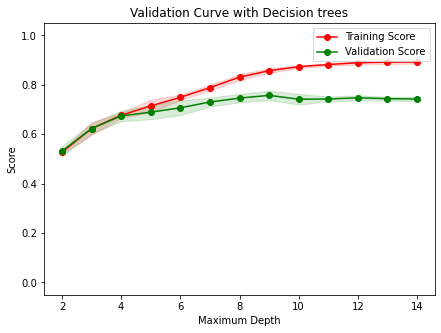

In [14]:
# validation curve
from sklearn.model_selection import validation_curve
# Vary the max_depth parameter from 1 to 15
max_depth = range(2,15)
# random_search decision tree results
DT_randomsearched = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=5,
                       min_samples_split=10, random_state=6666)
# Calculate the training and testing scores
train_scores, test_scores = validation_curve(DT_randomsearched, X_train, y_train, \
    param_name = "max_depth", param_range = max_depth, cv = cv)

# Find the mean and standard deviation for smoothing
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(7, 5))
plt.title('Validation Curve with Decision trees')
plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
plt.fill_between(max_depth, train_mean - train_std, \
    train_mean + train_std, alpha = 0.15, color = 'r')
plt.fill_between(max_depth, test_mean - test_std, \
    test_mean + test_std, alpha = 0.15, color = 'g')
    
 # Visual aesthetics
plt.legend(loc = 'best')
plt.xlabel('Maximum Depth')
plt.ylabel('Score')
plt.ylim([-0.05,1.05])
plt.show()

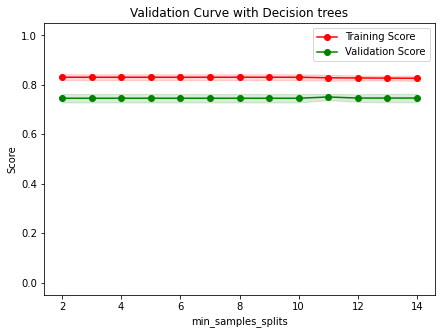

In [15]:
# validation curve
# Vary the min_samples_splits parameter from 1 to 15
min_samples_split = range(2,15)
# random_search decision tree results
DT_maxdepth_tuned = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=5,
                       min_samples_split=10, random_state=6666)
# Calculate the training and testing scores
train_scores, test_scores = validation_curve(DT_maxdepth_tuned, X_train, y_train, \
    param_name = "min_samples_split", param_range = min_samples_split, cv = cv)

    # Find the mean and standard deviation for smoothing
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
plt.figure(figsize=(7, 5))
plt.title('Validation Curve with Decision trees')
plt.plot(min_samples_split, train_mean, 'o-', color = 'r', label = 'Training Score')
plt.plot(min_samples_split, test_mean, 'o-', color = 'g', label = 'Validation Score')
plt.fill_between(min_samples_split, train_mean - train_std, \
    train_mean + train_std, alpha = 0.15, color = 'r')
plt.fill_between(min_samples_split, test_mean - test_std, \
    test_mean + test_std, alpha = 0.15, color = 'g')
    
 # Visual aesthetics
plt.legend(loc = 'best')
plt.xlabel('min_samples_splits')
plt.ylabel('Score')
plt.ylim([-0.05,1.05])
plt.show()

Text(0.5, 1.0, 'Decision trees')

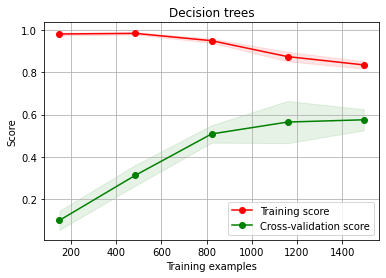

In [19]:
# learning curve
train_sizes, train_scores, test_scores = learning_curve(DT_maxdepth_tuned , X, Y)

#fit_times_mean = np.mean(fit_times,axis = 1)
#fit_times_std = np.std(fit_times,axis = 1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Decision trees")

## Neural Networks

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [21]:
# Defining a function to encode output column
from keras.utils import to_categorical
def encode(data):
    print('Shape of data (Before Encode):%s'%str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (After Encode):%s\n'%str(data.shape))
    return encoded

In [26]:
y_train_encoded = encode(y_train)

Shape of data (Before Encode):(1401,)
Shape of data (After Encode):(1401,)



In [27]:
y_test_encoded = encode(y_test)

Shape of data (Before Encode):(468,)
Shape of data (After Encode):(468,)



In [28]:
# Initialize the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 27, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

#Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),batch_size = 100, epochs = 1150)

Train on 1401 samples, validate on 468 samples
Epoch 1/1150
1401/1401 [==============================] - 1s 737us/step - loss: 1.9406 - accuracy: 0.2748 - val_loss: 1.9341 - val_accuracy: 0.2821
Epoch 2/1150
1401/1401 [==============================] - 0s 17us/step - loss: 1.9256 - accuracy: 0.3555 - val_loss: 1.9150 - val_accuracy: 0.3376
Epoch 3/1150
1401/1401 [==============================] - 0s 19us/step - loss: 1.8987 - accuracy: 0.3669 - val_loss: 1.8788 - val_accuracy: 0.3397
Epoch 4/1150
1401/1401 [==============================] - 0s 18us/step - loss: 1.8421 - accuracy: 0.3697 - val_loss: 1.8044 - val_accuracy: 0.3483
Epoch 5/1150
1401/1401 [==============================] - 0s 20us/step - loss: 1.7471 - accuracy: 0.3626 - val_loss: 1.7111 - val_accuracy: 0.3333
Epoch 6/1150
1401/1401 [==============================] - 0s 19us/step - loss: 1.6643 - accuracy: 0.3440 - val_loss: 1.6656 - val_accuracy: 0.3526
Epoch 7/1150
1401/1401 [==============================] - 0s 20us/step

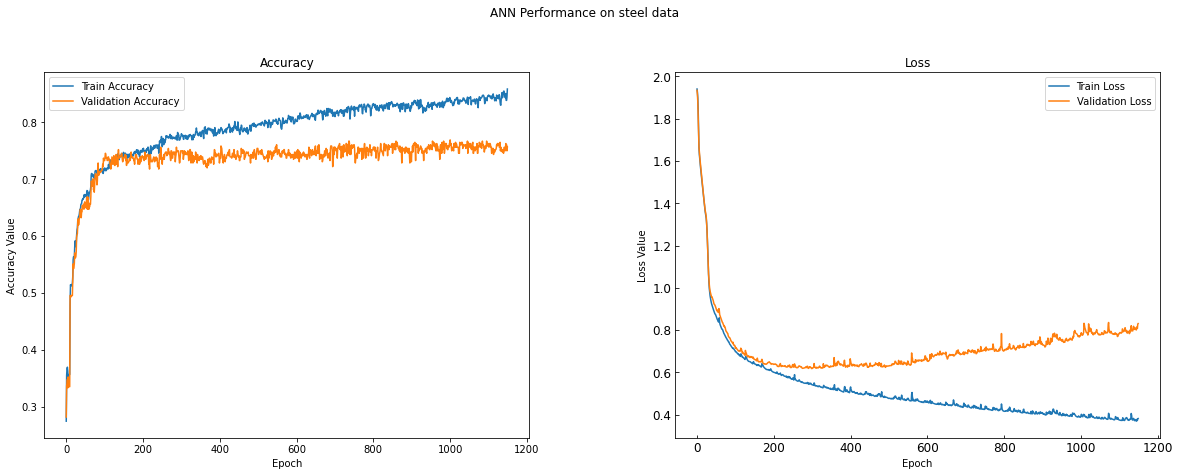

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('ANN Performance on steel data', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

#epochs = list(range(1,1151))
ax1.plot(range(1150), history.history['accuracy'], label='Train Accuracy')
ax1.plot(range(1150), history.history['val_accuracy'], label='Validation Accuracy')
plt.tick_params(direction="in", labelsize=12)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(range(1150), history.history['loss'], label='Train Loss')
ax2.plot(range(1150), history.history['val_loss'], label='Validation Loss')
plt.tick_params(direction="in", labelsize=12)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [32]:
# Initialize the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 27, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

#Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),batch_size = 1000, epochs = 1150)

Train on 1401 samples, validate on 468 samples
Epoch 1/1150
1401/1401 [==============================] - 0s 172us/step - loss: 1.9456 - accuracy: 0.1470 - val_loss: 1.9445 - val_accuracy: 0.2350
Epoch 2/1150
1401/1401 [==============================] - 0s 8us/step - loss: 1.9442 - accuracy: 0.2834 - val_loss: 1.9430 - val_accuracy: 0.3376
Epoch 3/1150
1401/1401 [==============================] - 0s 5us/step - loss: 1.9426 - accuracy: 0.3533 - val_loss: 1.9413 - val_accuracy: 0.3483
Epoch 4/1150
1401/1401 [==============================] - 0s 4us/step - loss: 1.9408 - accuracy: 0.3969 - val_loss: 1.9396 - val_accuracy: 0.3697
Epoch 5/1150
1401/1401 [==============================] - 0s 4us/step - loss: 1.9390 - accuracy: 0.3976 - val_loss: 1.9378 - val_accuracy: 0.3932
Epoch 6/1150
1401/1401 [==============================] - 0s 7us/step - loss: 1.9370 - accuracy: 0.4083 - val_loss: 1.9358 - val_accuracy: 0.3953
Epoch 7/1150
1401/1401 [==============================] - 0s 4us/step - los

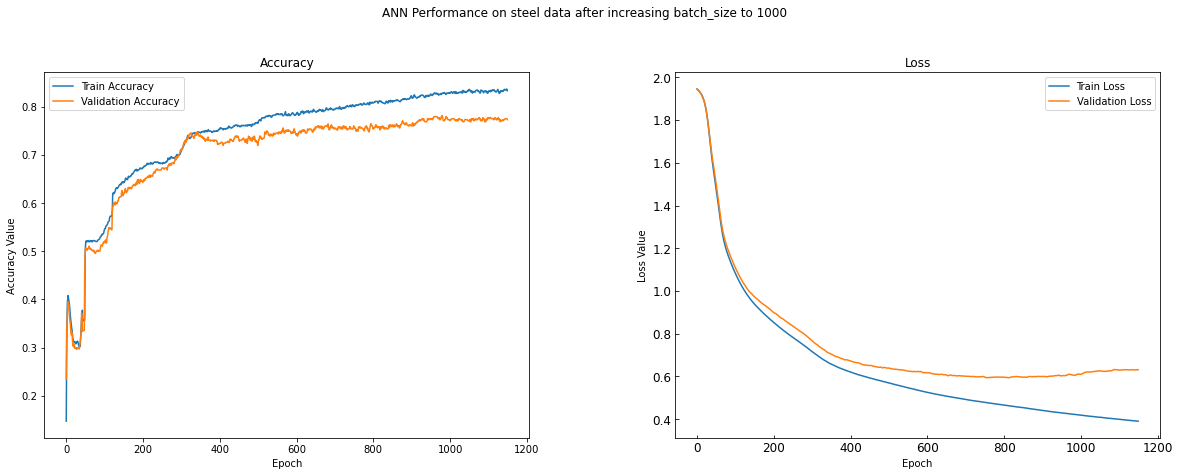

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('ANN Performance on steel data after increasing batch_size to 1000', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

#epochs = list(range(1,1151))
ax1.plot(range(1150), history.history['accuracy'], label='Train Accuracy')
ax1.plot(range(1150), history.history['val_accuracy'], label='Validation Accuracy')
plt.tick_params(direction="in", labelsize=12)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(range(1150), history.history['loss'], label='Train Loss')
ax2.plot(range(1150), history.history['val_loss'], label='Validation Loss')
plt.tick_params(direction="in", labelsize=12)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Boosting

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
#defalut model
GBC = GradientBoostingClassifier().fit(X_train, y_train)
GBC.score(X_test, y_test)

0.7841880341880342

In [36]:
# Random search hyperparameter tuning
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

n_iter_search = 300
cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=6666)
random_search = RandomizedSearchCV(GBC, param_distributions=parameters, cv=cv,n_iter=n_iter_search, random_state=666)
from time import time
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
best_estimator_GBC= random_search.best_estimator_
print(best_estimator_GBC)
print(random_search.best_score_)

D:\ANACONDA\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 100 is smaller than n_iter=300. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV took 5954.17 seconds for 300 candidates parameter settings.
GradientBoostingClassifier(max_depth=7, n_estimators=250)
0.7957295373665481


In [55]:
GBC_finally = GradientBoostingClassifier(max_depth=7, n_estimators=250).fit(X_train, y_train)

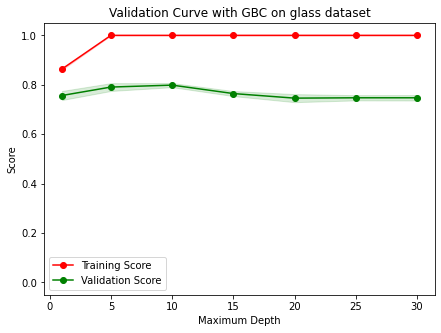

In [57]:
# validation curve
from sklearn.model_selection import validation_curve
# Vary the max_depth parameter from 1 to 15
max_depth = [1,5,10,15,20,25,30]

# Calculate the training and testing scores
train_scores, test_scores = validation_curve(GBC_finally, X_train, y_train, \
    param_name = "max_depth", param_range = max_depth, cv = cv)

# Find the mean and standard deviation for smoothing
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

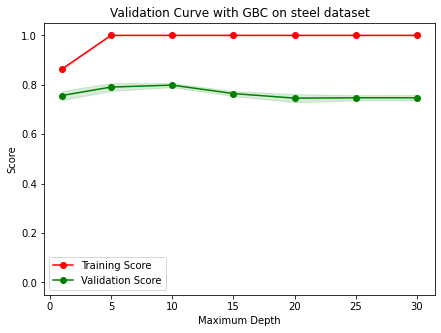

In [58]:
# Plot the validation curve
plt.figure(figsize=(7, 5))
plt.title('Validation Curve with GBC on steel dataset')
plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
plt.fill_between(max_depth, train_mean - train_std, \
    train_mean + train_std, alpha = 0.15, color = 'r')
plt.fill_between(max_depth, test_mean - test_std, \
    test_mean + test_std, alpha = 0.15, color = 'g')
    
 # Visual aesthetics
plt.legend(loc = 'best')
plt.xlabel('Maximum Depth')
plt.ylabel('Score')
plt.ylim([-0.05,1.05])
plt.show()

Text(0.5, 1.0, 'Gradient Boosting Classifier')

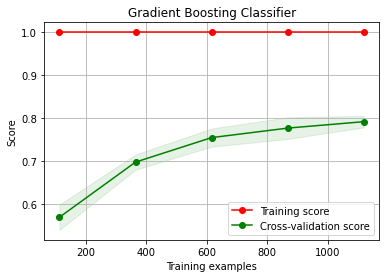

In [56]:
# learning curve
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(GBC_finally, X_train, y_train, cv=cv,train_sizes=np.linspace(.1, 1.0, 5),return_times=True)

fit_times_mean = np.mean(fit_times,axis = 1)
fit_times_std = np.std(fit_times,axis = 1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Gradient Boosting Classifier")

## Support Vector Machine

In [47]:
#rbf scores the best
from sklearn import svm
kernels=['linear','poly','rbf','sigmoid']
scores=[]
for i in kernels:
    clf = svm.SVC(kernel = i)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
scores

[0.7435897435897436,
 0.7414529914529915,
 0.7692307692307693,
 0.6089743589743589]

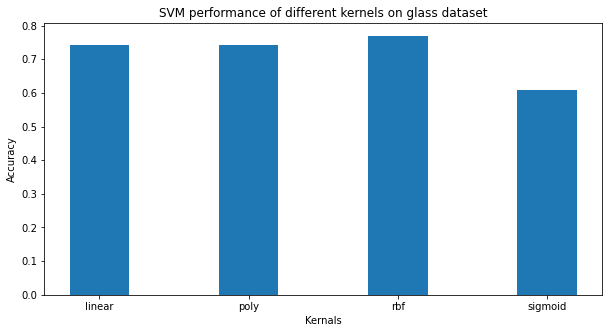

In [48]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(kernels, scores,
        width = 0.4)
 
plt.xlabel("Kernals")
plt.ylabel("Accuracy")
plt.title("SVM performance of different kernels on glass dataset")
plt.show()

In [39]:
# using kernal rbf to do grid search
# defining parameter range
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
grid.fit(X_train, y_train)
# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV 2/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV 3/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV 4/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV 5/5] END ...................C=0.001, gamma=1, kernel=rbf; total time=   0.0s
[CV 1/5] END .................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 2/5] END .................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 3/5] END .................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 4/5] END .................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 5/5] END .................C=0.001, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 1/5] END ................C=0.001, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 2/5] END ................C=0.001, gamma=0.0

In [46]:
print(grid.best_estimator_.score(X_test, y_test))
my_best=SVC(C=0.1, gamma=0.1)
my_best.fit(X_train,y_train)
print(my_best.score(X_test,y_test))

0.7670940170940171
0.6816239316239316


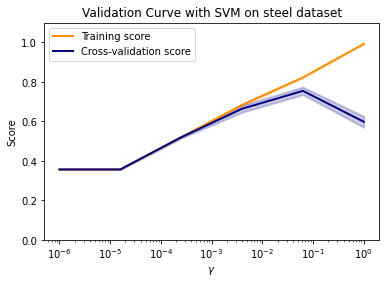

In [51]:
#different gamma
param_range = np.logspace(-6, -0, 6)
SVC_best = SVC(C=1, gamma=0.1,random_state=6666)
train_scores, test_scores = validation_curve(
    SVC(C=1), X_train, y_train, param_name="gamma", param_range=param_range,scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM on steel dataset")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

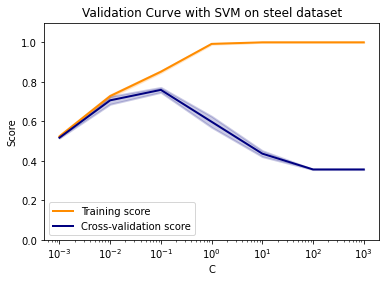

In [52]:
#different C
param_range = np.logspace(-3, 3, 7)
SVC_best = SVC(C=1, gamma=0.1,random_state=6666)
train_scores, test_scores = validation_curve(
    SVC(gamma=0.1), X_train, y_train, param_name="gamma", param_range=param_range,scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM on steel dataset")
plt.xlabel(r"C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Text(0.5, 1.0, 'Support Vector Classifier on steel data')

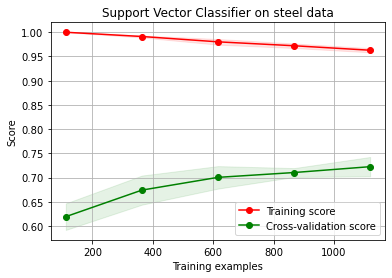

In [43]:
# learning curve
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(SVC_best, X_train, y_train, cv=cv,train_sizes=np.linspace(.1, 1.0, 5),return_times=True)

fit_times_mean = np.mean(fit_times,axis = 1)
fit_times_std = np.std(fit_times,axis = 1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Support Vector Classifier on steel data")

## KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.7564102564102564

[[1.         1.         1.         1.         1.        ]
 [0.84196429 0.84910714 0.84910714 0.85982143 0.85714286]
 [0.83571429 0.85357143 0.8375     0.85089286 0.84910714]
 [0.80892857 0.81964286 0.81607143 0.81696429 0.82321429]
 [0.80089286 0.81160714 0.80892857 0.82053571 0.81339286]
 [0.79375    0.79285714 0.79553571 0.80714286 0.79732143]
 [0.79107143 0.78392857 0.78660714 0.80089286 0.79107143]
 [0.78214286 0.77053571 0.78125    0.79375    0.78392857]
 [0.77410714 0.78392857 0.76964286 0.78660714 0.77767857]
 [0.77053571 0.77678571 0.75982143 0.78125    0.77232143]
 [0.75982143 0.77053571 0.75892857 0.76964286 0.76964286]
 [0.76160714 0.75892857 0.75178571 0.76160714 0.76607143]
 [0.74285714 0.75446429 0.74732143 0.75803571 0.75982143]
 [0.7375     0.74732143 0.74196429 0.75267857 0.75267857]
 [0.73214286 0.74732143 0.73303571 0.75       0.74910714]
 [0.73214286 0.73482143 0.72857143 0.74732143 0.73928571]
 [0.72410714 0.73125    0.73214286 0.74910714 0.74017857]
 [0.72589286 0

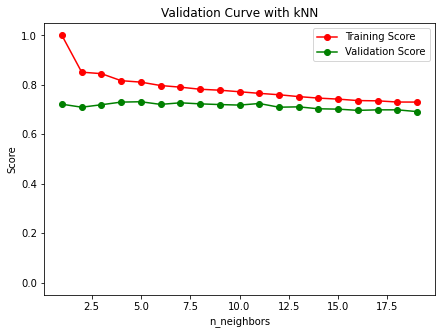

In [60]:
# validation curve
# Vary the max_depth parameter from 1 to 15
n_neighbors = range(1,20)
# random_search decision tree results
#KNN_randomsearched = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=8, weights='distance')
# Calculate the training and testing scores
train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, \
    param_name = "n_neighbors", param_range = n_neighbors, cv = cv)
print(train_scores)
# Find the mean and standard deviation for smoothing
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(7, 5))
plt.title('Validation Curve with kNN')
plt.plot(n_neighbors, train_mean, 'o-', color = 'r', label = 'Training Score')
plt.plot(n_neighbors, test_mean, 'o-', color = 'g', label = 'Validation Score')
# plt.fill_between(max_depth, train_mean - train_std, \
#     train_mean + train_std, alpha = 0.15, color = 'r')
# plt.fill_between(max_depth, test_mean - test_std, \
#     test_mean + test_std, alpha = 0.15, color = 'g')
    
 # Visual aesthetics
plt.legend(loc = 'best')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.ylim([-0.05,1.05])
plt.show()

Text(0.5, 1.0, 'kNN Classifier on steel data')

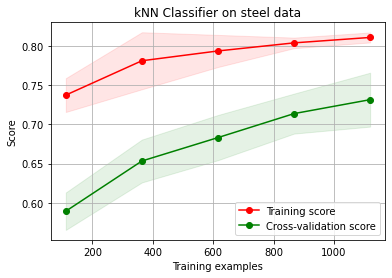

In [62]:
# learning curve
train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(KNeighborsClassifier(n_neighbors=5), X_train, y_train, cv=cv,train_sizes=np.linspace(.1, 1.0, 5),return_times=True)

fit_times_mean = np.mean(fit_times,axis = 1)
fit_times_std = np.std(fit_times,axis = 1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("kNN Classifier on steel data")